In [20]:
# Import necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
import numpy as np
import warnings; warnings.simplefilter('ignore')

In [21]:
# Import daily stock and sentiment data

daily = pd.read_csv('data_for_timeseries.csv').rename(columns = {'Unnamed: 0':'Date'})
daily.set_index(pd.to_datetime(daily['Date']), inplace = True)
daily = daily.drop(columns = ['Date'])
daily.head()

,open_close_diff,pos_neg,close_low_diff,sentiment_1,sentiment_2,s1_no_0,s2_no_0,s1_scaled,s2_scaled
Date,,,,,,,,,
2018-01-04,-4.380005,-1.0,-11.570007,-0.139748,-0.054146,-0.204682,-0.087235,-0.428520,0.447675
2018-01-05,2.000000,1.0,-2.619995,-0.062928,0.012496,-0.086355,0.027508,-0.178162,-0.428520
2018-01-08,-0.579987,-1.0,-1.079987,0.112147,0.040083,0.166073,0.082215,0.392404,-0.178162
2018-01-09,-1.250000,-1.0,-9.010010,0.134637,0.074042,0.195672,0.120457,0.465698,0.392404
2018-01-10,-1.489990,-1.0,-3.690002,0.215636,0.058817,0.381270,0.170848,0.729674,0.465698


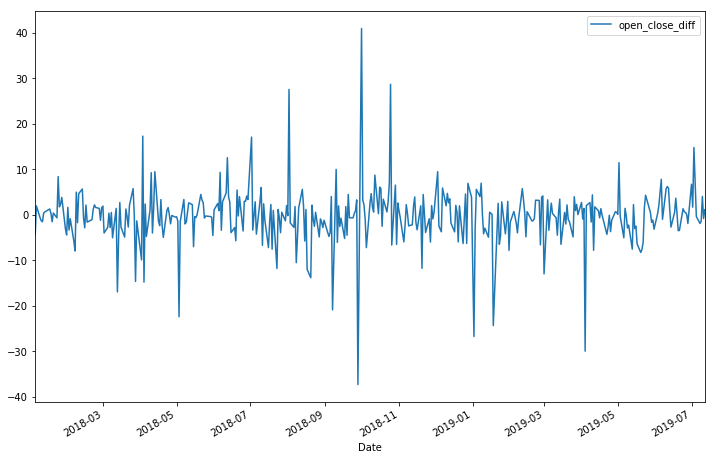

In [22]:
# View line graphs for stock info series

daily.open_close_diff.plot(figsize = (12,8), subplots=True, legend=True);

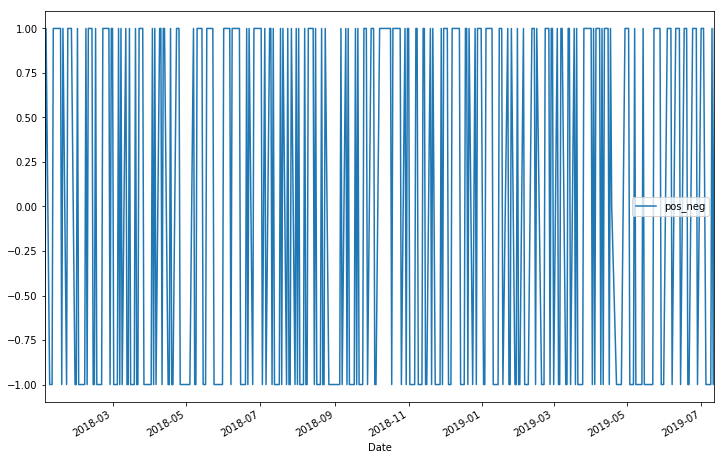

In [23]:

daily.pos_neg.plot(figsize = (12,8), subplots=True, legend=True);

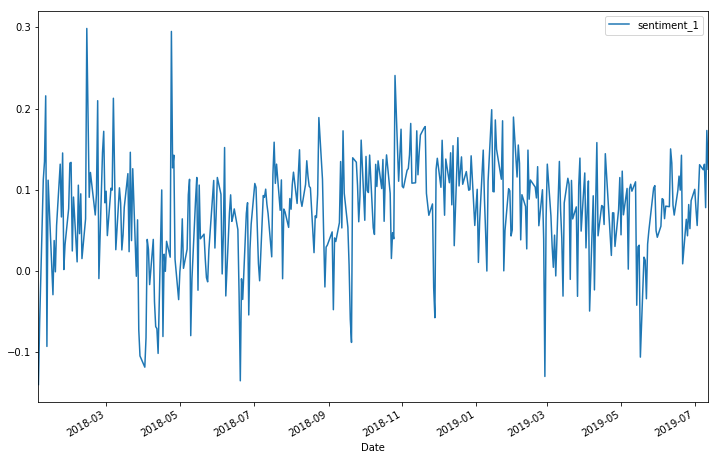

In [24]:
# View line graphs for sentiment info series

daily.sentiment_1.plot(figsize = (12,8), subplots=True, legend=True);       

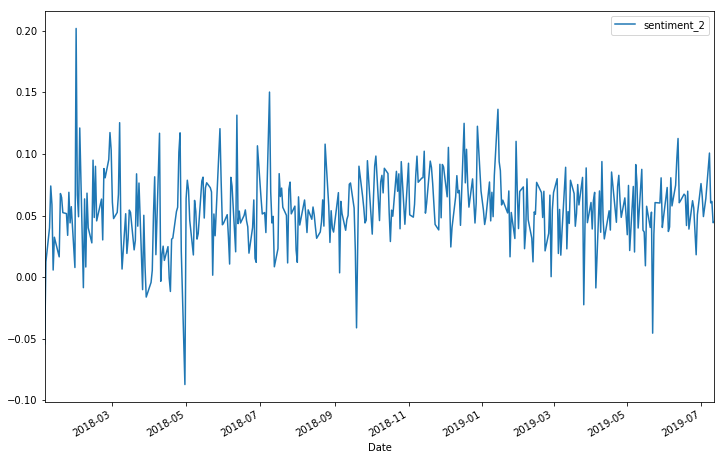

In [25]:
# View line graphs for sentiment info series

daily.sentiment_2.plot(figsize = (12,8), subplots=True, legend=True);  

## Stationarity

In [26]:
# Create function that uses the Dickey-Fuller Test to check that a series is stationary

def check_stationarity(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)  

In [27]:
# Check if daily.open_close_diff is stationary

check_stationarity(daily.open_close_diff)

Results of Dickey-Fuller Test:
Test Statistic                 -22.916022
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    381.000000
Critical Value (1%)             -3.447631
Critical Value (5%)             -2.869156
Critical Value (10%)            -2.570827
dtype: float64


In [28]:
# Check if daily.pos_neg is stationary

check_stationarity(daily.pos_neg)

Results of Dickey-Fuller Test:
Test Statistic                 -19.939334
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    381.000000
Critical Value (1%)             -3.447631
Critical Value (5%)             -2.869156
Critical Value (10%)            -2.570827
dtype: float64


## ACF & PACF 

In [29]:
# Function to plot ACF and PACF for a timeseries

def plot_acf_pacf(timeseries):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    # Plot the ACF
    fig = sm.graphics.tsa.plot_acf(timeseries.iloc[1:], lags=18, ax=ax1)
    ax2 = fig.add_subplot(212)
    #plot the PACF
    fig = sm.graphics.tsa.plot_pacf(timeseries.iloc[1:], lags=18, ax=ax2)
    

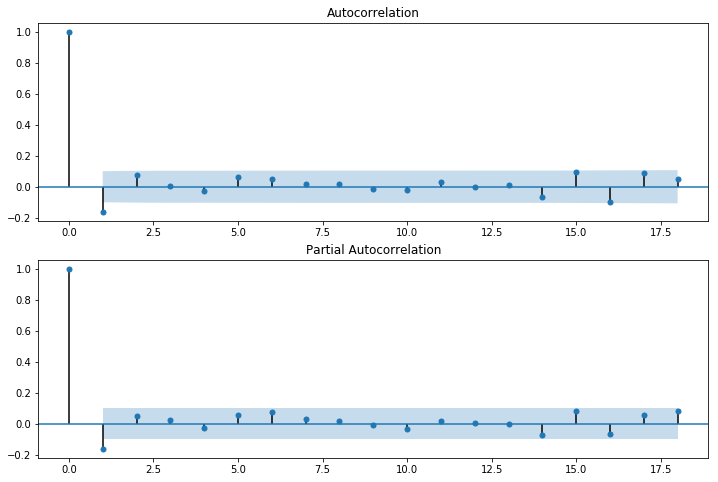

In [30]:
plot_acf_pacf(daily.open_close_diff)

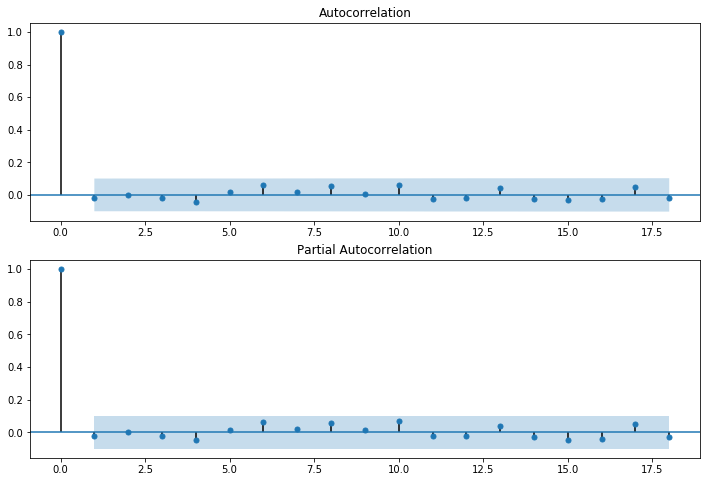

In [31]:
plot_acf_pacf(daily.pos_neg)

In [33]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = set(classes)#[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [53]:
def model_and_predict(endogenous, exongenous):
    df = daily[[endogenous, exongenous]]
    train_start,train_end = '2018-01-05','2019-02-25'
    test_start,test_end = '2019-02-26','2019-07-12'
    train = df[endogenous][train_start:train_end].dropna()
    test = df[endogenous][test_start:test_end].dropna()
    exog_train = df.drop([endogenous],axis = 1)[train_start:train_end].dropna()
    exog_test = df.drop([endogenous],axis = 1)[test_start:test_end].dropna()
    best_p_values = []
    best_mae = float('inf')
    final_order = (0,0,0)
    for p in [0,1,2,3,4,5]:
        for d in [0,1,2,3,4,5]:
            for q in [0,1,2,3,4,5]:
                try:
                    order_test = (p,q,d)
                    arimax = sm.tsa.statespace.SARIMAX(train, order=order_test, seasonal_order=(0,0,0,0), exog=exog_train).fit()
                    if arimax.pvalues[0] < 0.1:
                        pred_test = arimax.predict(start=285, end=380, exog = exog_test)
                        #mse = mean_squared_error(test,pred_test)
                        mae = mean_absolute_error(test, pred_test)
                        #if mse < best_mse:
                        if mae < best_mae:
                            #best_mse = mse
                            best_mae = mae
                            final_order = order_test
                except:
                    continue
    print('Final order used in model: {}'.format(final_order))
    print('Best MAE : {}'.format(best_mae))
    model = sm.tsa.statespace.SARIMAX(train, order=final_order, seasonal_order=(0,0,0,0), exog=exog_train).fit()
    print(model.summary())
    pred = model.predict(start=285, end=380, exog = exog_test)
    print('ARIMAX model MSE:{}'.format(mean_squared_error(test,pred)))
    predictions_df = pd.DataFrame(pred, columns= ['predictions'])
    predictions_df.set_index(exog_test.index, inplace=True)
    predictions_df = pd.merge(pd.DataFrame(test), predictions_df, how='inner', left_index=True, right_index=True)
    if endogenous == 'pos_neg':
        predictions_df['class_predictions'] = predictions_df.predictions.map(lambda x: 1 if (x >0) else(-1 if x <0 else 0))
        print('Accuracy: ', accuracy_score(predictions_df[endogenous], predictions_df.class_predictions))
        print('Precision: ', precision_score(predictions_df[endogenous], predictions_df.class_predictions, average=None))
        print('\n')
        print(confusion_matrix(predictions_df[endogenous], predictions_df.class_predictions))
    else:
        predictions_df[endogenous+'_class'] = predictions_df[endogenous].map(lambda x: 1 if (x >0) else(-1 if x <0 else 0))
        predictions_df['class_predictions'] = predictions_df.predictions.map(lambda x: 1 if (x >0) else(-1 if x <0 else 0))
        print('Precision: ', precision_score(predictions_df[endogenous+'_class'], predictions_df.class_predictions, average=None))
        print('\n')
        print(confusion_matrix(predictions_df[endogenous+'_class'], predictions_df.class_predictions))
    print('\n')
    print('Max Test Value:', max(test))
    print('Min Test Value:', min(test))
    print('Max Prediction:', max(predictions_df.predictions))
    print('Min Prediction:', min(predictions_df.predictions))
    return predictions_df

# MODEL & PREDICT WITH ARIMAX

### Model with open_close_diff & sentiment_1

In [38]:
def model_and_predict(endogenous, exongenous):
    df = daily[[endogenous, exongenous]]
    train_start,train_end = '2018-01-05','2019-02-22'
    test_start,test_end = '2019-02-26','2019-07-12'
    train = df[endogenous][train_start:train_end].dropna()
    test = df[endogenous][test_start:test_end].dropna()
    exog_train = df.drop([endogenous],axis = 1)[train_start:train_end].dropna()
    exog_test = df.drop([endogenous],axis = 1)[test_start:test_end].dropna()
    arimax = sm.tsa.statespace.SARIMAX(train, order=[2, 5, 0], seasonal_order=(0,0,0,0), exog=exog_train).fit()
    print(arimax.summary())
    print('\n')
    print(arimax.pvalues[0])
    print('\n')
    pred = arimax.predict(start=221, end=296, exog = exog_test)
    print('ARIMAX model MSE:{}'.format(mean_squared_error(test,pred)))
    predictions_df = pd.DataFrame(pred, columns= ['predictions'])
    predictions_df.set_index(exog_test.index, inplace=True)
    predictions_df = pd.merge(pd.DataFrame(test), predictions_df, how='inner', left_index=True, right_index=True)
    #predictions_df['class_predictions'] = predictions_df.predictions.map(lambda x: 1 if (x >0) else(-1 if x <0 else 0))
    if endogenous == 'pos_neg':
        predictions_df['class_predictions'] = predictions_df.predictions.map(lambda x: 1 if (x >0) else(-1 if x <0 else 0))
        print('Accuracy: ', accuracy_score(predictions_df[endogenous], predictions_df.class_predictions))
        print('Precision: ', precision_score(predictions_df[endogenous], predictions_df.class_predictions, average=None))
    else:
        predictions_df[endogenous+'_class']= predictions_df[endogenous].map(lambda x: 1 if (x >0) else(-1 if x <0 else 0))
        predictions_df['class_predictions'] = predictions_df.predictions.map(lambda x: 1 if (x >0) else(-1 if x <0 else 0))
        print('Precision: ', precision_score(predictions_df[endogenous+'_class'], predictions_df.class_predictions, average=None))
    return predictions_df.head(10)

In [54]:
model_and_predict('open_close_diff', 'sentiment_1')

(3, 1, 4)
3.2560087064581062
                           Statespace Model Results                           
Dep. Variable:        open_close_diff   No. Observations:                  285
Model:               SARIMAX(3, 1, 4)   Log Likelihood                -941.106
Date:                Thu, 19 Sep 2019   AIC                           1900.212
Time:                        14:26:57   BIC                           1933.053
Sample:                             0   HQIC                          1913.379
                                - 285                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
sentiment_1   -14.7134      5.317     -2.767      0.006     -25.135      -4.292
ar.L1          -0.3629      0.497     -0.730      0.465      -1.337       0.611
ar.L2          -1.0

,open_close_diff,predictions,open_close_diff_class,class_predictions
Date,,,,
2019-02-26,-6.549988,-0.483705,-1,-1
2019-02-27,3.920014,3.212611,1,1
2019-02-28,4.180023,0.007063,1,1
2019-03-01,-12.940003,-1.370149,-1,-1
2019-03-04,3.329986,-0.168452,1,-1
2019-03-05,-3.359985,0.747065,-1,1
2019-03-06,-0.059998,0.801696,-1,1
2019-03-07,2.600006,-0.083020,1,-1
2019-03-08,0.320008,1.032204,1,1


### Model with open_close_diff & sentiment_2

In [41]:
model_and_predict('open_close_diff', 'sentiment_2')

(0, 0, 0)
inf
                           Statespace Model Results                           
Dep. Variable:        open_close_diff   No. Observations:                  285
Model:                        SARIMAX   Log Likelihood                -944.721
Date:                Thu, 19 Sep 2019   AIC                           1893.442
Time:                        14:17:40   BIC                           1900.747
Sample:                             0   HQIC                          1896.370
                                - 285                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
sentiment_2    -4.8243      6.400     -0.754      0.451     -17.369       7.720
sigma2         44.3337      1.458     30.413      0.000      41.477      47.191
Ljung-Box (Q):                    

,open_close_diff,predictions,open_close_diff_class,class_predictions
Date,,,,
2019-02-26,-6.549988,-0.321510,-1,-1
2019-02-27,3.920014,-0.002157,1,-1
2019-02-28,4.180023,-0.263796,1,-1
2019-03-01,-12.940003,-0.331485,-1,-1
2019-03-04,3.329986,-0.385718,1,-1
2019-03-05,-3.359985,-0.093012,-1,-1
2019-03-06,-0.059998,-0.265480,-1,-1
2019-03-07,2.600006,-0.086438,1,-1
2019-03-08,0.320008,-0.179993,1,-1


### Model with open_close_diff & s1_no_0

In [42]:
model_and_predict('open_close_diff', 's1_no_0')

(0, 1, 0)
4.9143803852278864
                           Statespace Model Results                           
Dep. Variable:        open_close_diff   No. Observations:                  285
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1061.501
Date:                Thu, 19 Sep 2019   AIC                           2127.002
Time:                        14:18:26   BIC                           2134.300
Sample:                             0   HQIC                          2129.928
                                - 285                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
s1_no_0      -14.1752      6.963     -2.036      0.042     -27.823      -0.528
sigma2       103.2840      3.925     26.315      0.000      95.591     110.977
Ljung-Box (Q):         

,open_close_diff,predictions,open_close_diff_class,class_predictions
Date,,,,
2019-02-26,-6.549988,4.294845,-1,1
2019-02-27,3.920014,7.357383,1,1
2019-02-28,4.180023,3.604684,1,1
2019-03-01,-12.940003,2.339762,-1,1
2019-03-04,3.329986,3.751468,1,1
2019-03-05,-3.359985,4.285276,-1,1
2019-03-06,-0.059998,4.913543,-1,1
2019-03-07,2.600006,4.092670,1,1
2019-03-08,0.320008,5.138989,1,1


### Model with open_close_diff & s2_no_0

In [43]:
model_and_predict('open_close_diff', 's2_no_0')

(3, 3, 0)
1373.444504015777
                           Statespace Model Results                           
Dep. Variable:        open_close_diff   No. Observations:                  285
Model:               SARIMAX(3, 3, 0)   Log Likelihood               -1137.986
Date:                Thu, 19 Sep 2019   AIC                           2285.973
Time:                        14:19:09   BIC                           2304.182
Sample:                             0   HQIC                          2293.275
                                - 285                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
s2_no_0      -13.4376      7.962     -1.688      0.091     -29.042       2.167
ar.L1         -1.6381      0.033    -49.077      0.000      -1.704      -1.573
ar.L2         -1.3130   

,open_close_diff,predictions,open_close_diff_class,class_predictions
Date,,,,
2019-02-26,-6.549988,7.348430,-1,1
2019-02-27,3.920014,12.317340,1,1
2019-02-28,4.180023,15.802845,1,1
2019-03-01,-12.940003,21.036483,-1,1
2019-03-04,3.329986,27.624748,1,1
2019-03-05,-3.359985,35.410893,-1,1
2019-03-06,-0.059998,42.899224,-1,1
2019-03-07,2.600006,52.510001,1,1
2019-03-08,0.320008,61.482598,1,1


### Model with open_close_diff & s1_scaled

In [44]:
model_and_predict('open_close_diff', 's1_scaled')

(0, 1, 0)
5.127963930705228
                           Statespace Model Results                           
Dep. Variable:        open_close_diff   No. Observations:                  285
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1060.504
Date:                Thu, 19 Sep 2019   AIC                           2125.009
Time:                        14:19:51   BIC                           2132.307
Sample:                             0   HQIC                          2127.935
                                - 285                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
s1_scaled     -7.1402      3.081     -2.318      0.020     -13.178      -1.102
sigma2       102.5670      4.275     23.994      0.000      94.189     110.945
Ljung-Box (Q):          

,open_close_diff,predictions,open_close_diff_class,class_predictions
Date,,,,
2019-02-26,-6.549988,4.612941,-1,1
2019-02-27,3.920014,8.548833,1,1
2019-02-28,4.180023,4.020939,1,1
2019-03-01,-12.940003,2.466700,-1,1
2019-03-04,3.329986,3.946044,1,1
2019-03-05,-3.359985,4.813114,-1,1
2019-03-06,-0.059998,5.421731,-1,1
2019-03-07,2.600006,4.500639,1,1
2019-03-08,0.320008,5.668980,1,1


### Model with open_close_diff & s2_scaled

In [45]:
model_and_predict('open_close_diff', 's2_scaled')

(2, 5, 1)
68477.98746022987
                           Statespace Model Results                           
Dep. Variable:        open_close_diff   No. Observations:                  285
Model:               SARIMAX(2, 5, 1)   Log Likelihood               -1307.483
Date:                Thu, 19 Sep 2019   AIC                           2624.966
Time:                        14:20:39   BIC                           2643.140
Sample:                             0   HQIC                          2632.255
                                - 285                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
s2_scaled     -5.3007      3.057     -1.734      0.083     -11.292       0.691
ar.L1         -1.4372      0.030    -48.580      0.000      -1.495      -1.379
ar.L2         -0.7210   

,open_close_diff,predictions,open_close_diff_class,class_predictions
Date,,,,
2019-02-26,-6.549988,1.718414,-1,1
2019-02-27,3.920014,-4.719049,1,-1
2019-02-28,4.180023,-15.620425,1,-1
2019-03-01,-12.940003,-39.853487,-1,-1
2019-03-04,3.329986,-73.616237,1,-1
2019-03-05,-3.359985,-115.008058,-1,-1
2019-03-06,-0.059998,-171.414581,-1,-1
2019-03-07,2.600006,-242.575413,1,-1
2019-03-08,0.320008,-331.442515,1,-1


### Model with pos_neg & sentiment_1

In [46]:
model_and_predict('pos_neg', 'sentiment_1')

(2, 2, 1)
0.9416497995833856
                           Statespace Model Results                           
Dep. Variable:                pos_neg   No. Observations:                  285
Model:               SARIMAX(2, 2, 1)   Log Likelihood                -446.816
Date:                Thu, 19 Sep 2019   AIC                            903.632
Time:                        14:21:39   BIC                            921.860
Sample:                             0   HQIC                           910.941
                                - 285                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
sentiment_1    -1.7291      0.905     -1.911      0.056      -3.502       0.044
ar.L1          -0.6797      0.069     -9.909      0.000      -0.814      -0.545
ar.L2          -0.3

,pos_neg,predictions,class_predictions
Date,,,
2019-02-26,-1.0,0.469887,1
2019-02-27,1.0,1.175538,1
2019-02-28,1.0,0.763242,1
2019-03-01,-1.0,0.575117,1
2019-03-04,1.0,0.763794,1
2019-03-05,-1.0,0.803062,1
2019-03-06,-1.0,0.846215,1
2019-03-07,1.0,0.792642,1
2019-03-08,1.0,0.875559,1


### Model with pos_neg & sentiment_2

In [47]:
model_and_predict('pos_neg', 'sentiment_2')

(0, 0, 0)
inf
                           Statespace Model Results                           
Dep. Variable:                pos_neg   No. Observations:                  285
Model:                        SARIMAX   Log Likelihood                -404.368
Date:                Thu, 19 Sep 2019   AIC                            812.736
Time:                        14:22:21   BIC                            820.041
Sample:                             0   HQIC                           815.665
                                - 285                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
sentiment_2     0.2236    125.549      0.002      0.999    -245.848     246.295
sigma2          0.9998    561.688      0.002      0.999   -1099.889    1101.889
Ljung-Box (Q):                    

,pos_neg,predictions,class_predictions
Date,,,
2019-02-26,-1.0,0.014903,1
2019-02-27,1.0,0.000100,1
2019-02-28,1.0,0.012228,1
2019-03-01,-1.0,0.015365,1
2019-03-04,1.0,0.017879,1
2019-03-05,-1.0,0.004311,1
2019-03-06,-1.0,0.012306,1
2019-03-07,1.0,0.004007,1
2019-03-08,1.0,0.008343,1


### Model with pos_neg & s1_no_0

In [48]:
model_and_predict('pos_neg', 's1_no_0')

(2, 2, 1)
0.9407173438009894
                           Statespace Model Results                           
Dep. Variable:                pos_neg   No. Observations:                  285
Model:               SARIMAX(2, 2, 1)   Log Likelihood                -446.618
Date:                Thu, 19 Sep 2019   AIC                            903.236
Time:                        14:23:10   BIC                            921.463
Sample:                             0   HQIC                           910.544
                                - 285                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
s1_no_0       -1.2871      0.634     -2.031      0.042      -2.529      -0.045
ar.L1         -0.6788      0.069     -9.863      0.000      -0.814      -0.544
ar.L2         -0.3121  

,pos_neg,predictions,class_predictions
Date,,,
2019-02-26,-1.0,0.472895,1
2019-02-27,1.0,1.158783,1
2019-02-28,1.0,0.742214,1
2019-03-01,-1.0,0.557001,1
2019-03-04,1.0,0.762054,1
2019-03-05,-1.0,0.785753,1
2019-03-06,-1.0,0.841069,1
2019-03-07,1.0,0.780888,1
2019-03-08,1.0,0.872138,1


### Model with pos_neg & s2_no_0

In [49]:
model_and_predict('pos_neg', 's2_no_0')

(3, 4, 0)
4065.462048455436
                           Statespace Model Results                           
Dep. Variable:                pos_neg   No. Observations:                  285
Model:               SARIMAX(3, 4, 0)   Log Likelihood                -706.471
Date:                Thu, 19 Sep 2019   AIC                           1422.943
Time:                        14:23:57   BIC                           1441.134
Sample:                             0   HQIC                          1430.238
                                - 285                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
s2_no_0       -2.2127      1.136     -1.949      0.051      -4.438       0.013
ar.L1         -1.7647      0.054    -32.948      0.000      -1.870      -1.660
ar.L2         -1.5038   

,pos_neg,predictions,class_predictions
Date,,,
2019-02-26,-1.0,4.488823,1
2019-02-27,1.0,7.201428,1
2019-02-28,1.0,11.136624,1
2019-03-01,-1.0,16.023767,1
2019-03-04,1.0,22.319140,1
2019-03-05,-1.0,29.142439,1
2019-03-06,-1.0,37.855955,1
2019-03-07,1.0,47.342512,1
2019-03-08,1.0,58.289327,1


### Model with pos_neg & s1_scaled

In [50]:
model_and_predict('pos_neg', 's1_scaled')

(2, 2, 1)
0.9416728304198004
                           Statespace Model Results                           
Dep. Variable:                pos_neg   No. Observations:                  285
Model:               SARIMAX(2, 2, 1)   Log Likelihood                -446.816
Date:                Thu, 19 Sep 2019   AIC                            903.632
Time:                        14:24:41   BIC                            921.859
Sample:                             0   HQIC                           910.941
                                - 285                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
s1_scaled     -0.5316      0.278     -1.915      0.056      -1.076       0.013
ar.L1         -0.6797      0.069     -9.909      0.000      -0.814      -0.545
ar.L2         -0.3140  

,pos_neg,predictions,class_predictions
Date,,,
2019-02-26,-1.0,0.470158,1
2019-02-27,1.0,1.176281,1
2019-02-28,1.0,0.763352,1
2019-03-01,-1.0,0.575036,1
2019-03-04,1.0,0.763892,1
2019-03-05,-1.0,0.803297,1
2019-03-06,-1.0,0.846545,1
2019-03-07,1.0,0.792830,1
2019-03-08,1.0,0.875921,1


### Model with pos_neg & s2_scaled

In [51]:
model_and_predict('pos_neg', 's2_scaled')

(0, 4, 0)
146034.87897209844
                           Statespace Model Results                           
Dep. Variable:                pos_neg   No. Observations:                  285
Model:               SARIMAX(0, 4, 0)   Log Likelihood               -1004.363
Date:                Thu, 19 Sep 2019   AIC                           2012.727
Time:                        14:25:33   BIC                           2020.004
Sample:                             0   HQIC                          2015.645
                                - 285                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
s2_scaled      0.6522      0.388      1.680      0.093      -0.109       1.413
sigma2        74.4867      8.014      9.295      0.000      58.780      90.193
Ljung-Box (Q):         

,pos_neg,predictions,class_predictions
Date,,,
2019-02-26,-1.0,-4.168136,-1
2019-02-27,1.0,-18.629431,-1
2019-02-28,1.0,-46.044296,-1
2019-03-01,-1.0,-89.062432,-1
2019-03-04,1.0,-152.381651,-1
2019-03-05,-1.0,-239.660601,-1
2019-03-06,-1.0,-354.219463,-1
2019-03-07,1.0,-499.743727,-1
2019-03-08,1.0,-679.770458,-1


## BEST MODEL:

In [52]:
pd.set_option('display.max_rows', 1000)
model_and_predict('open_close_diff', 'sentiment_1')

(3, 1, 4)
3.2560087064581062
                           Statespace Model Results                           
Dep. Variable:        open_close_diff   No. Observations:                  285
Model:               SARIMAX(3, 1, 4)   Log Likelihood                -941.106
Date:                Thu, 19 Sep 2019   AIC                           1900.212
Time:                        14:26:17   BIC                           1933.053
Sample:                             0   HQIC                          1913.379
                                - 285                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
sentiment_1   -14.7134      5.317     -2.767      0.006     -25.135      -4.292
ar.L1          -0.3629      0.497     -0.730      0.465      -1.337       0.611
ar.L2          -1.0

,open_close_diff,predictions,open_close_diff_class,class_predictions
Date,,,,
2019-02-26,-6.549988,-0.483705,-1,-1
2019-02-27,3.920014,3.212611,1,1
2019-02-28,4.180023,0.007063,1,1
2019-03-01,-12.940003,-1.370149,-1,-1
2019-03-04,3.329986,-0.168452,1,-1
2019-03-05,-3.359985,0.747065,-1,1
2019-03-06,-0.059998,0.801696,-1,1
2019-03-07,2.600006,-0.083020,1,-1
2019-03-08,0.320008,1.032204,1,1


In [ ]:
pd.set_option('display.max_rows', 1000)
model_and_predict('open_close_diff', 'sentiment_1')

In [ ]:
pd.set_option('display.max_rows', 1000)
model_and_predict('pos_neg', 'sentiment_1')

In [ ]:
pd.set_option('display.max_rows', 1000)
model_and_predict('open_close_diff', 's2_no_0')

In [614]:
pd.set_option('display.max_rows', 1000)
model_and_predict('open_close_diff', 'sentiment_1')

(3, 1, 4)
3.2560087064581062
                           Statespace Model Results                           
Dep. Variable:        open_close_diff   No. Observations:                  285
Model:               SARIMAX(3, 1, 4)   Log Likelihood                -941.106
Date:                Thu, 01 Aug 2019   AIC                           1900.212
Time:                        09:36:49   BIC                           1933.053
Sample:                             0   HQIC                          1913.379
                                - 285                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
sentiment_1   -14.7134      5.317     -2.767      0.006     -25.135      -4.292
ar.L1          -0.3629      0.497     -0.730      0.465      -1.337       0.611
ar.L2          -1.0

,open_close_diff,predictions,open_close_diff_class,class_predictions
Date,,,,
2019-02-26,-6.549988,-0.483705,-1,-1
2019-02-27,3.920014,3.212611,1,1
2019-02-28,4.180023,0.007063,1,1
2019-03-01,-12.940003,-1.370149,-1,-1
2019-03-04,3.329986,-0.168452,1,-1
2019-03-05,-3.359985,0.747065,-1,1
2019-03-06,-0.059998,0.801696,-1,1
2019-03-07,2.600006,-0.083020,1,-1
2019-03-08,0.320008,1.032204,1,1
